In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Serial arduino --> python delay used in code
vDelay = 100; #(ms)

# Read all the data and clean it up
dataPath = 'b1001_201812210139.txt'
mystr = []
print('Cleaned up data looks like this:\n')
with open(dataPath, 'r') as var:
    for line in var:
        line = line.rstrip()
        if len(line) > 1:
            print(line)
            mystr.append(line)

# Get event keys and corresponding time stamps (as ints) in separate lists
keys = []
values = []
for i in mystr[4:-1]: # Slicing avoids the header and termination statement
    a,b = i.split(":")
    keys.append(a)
    values.append(int(b))

# Generate an array to hold the data
dataArray = np.zeros((len(values),7))
header = {'timestamps','event key','trial number','trial start (ITI)','rewarded','stimulus type','stimulus start (S1)'}
for i,j in enumerate(values):
    dataArray[i,0] = j
    dataArray[i,1] = ord(keys[i][0])

# Identify trial start and gabor onset timestamps
itemindex = np.where(dataArray==ord('X'))
Xindex = itemindex[0][:]
itemindex = np.where(dataArray==ord('Q'))
Qindex = itemindex[0][:]
np.append(Xindex,len(values)) # Pad the array for easy iterative processing
for i,j in enumerate(Xindex):
    if i < len(Xindex)-1:
        dataArray[Xindex[i]:Xindex[i+1]+1,2] = i # Trial number
        dataArray[Xindex[i]:Xindex[i+1]+1,3] = values[j] # Extract all ITI start times
        dataArray[Xindex[i]:Xindex[i+1]+1,5] = keys[Qindex[i]][1] # Extract stimulus type (<4 is stim 1, >3 is stim 2)
        dataArray[Xindex[i]:Xindex[i+1]+1,6] = values[Qindex[i]] + vDelay # Extract stimulus type (<4 is stim 1, <3 is stim 2)
        
        # Check for reward
        testt = dataArray[Xindex[i]:Xindex[i+1]+1,1] == ord('T')
        if testt.any():
            dataArray[Xindex[i]:Xindex[i+1]+1,4] = 1
        else:
            dataArray[Xindex[i]:Xindex[i+1]+1,4] = 0


Cleaned up data looks like this:

Experimenter: tor
Datetime: 201812210139
MouseID: b1001
Behavioural protocol started: 20181221013957
S:8866
Z1:8867
X1:8867
Q2:13330
W:14330
T:14430
U:14450
X2:14450
Q0:17681
W:18681
T:18781
U:18801
X3:18801
Q3:20438
W:21438
Y:21538
U:21558
X4:21558
Behavioural protocol ended: 20181221014011


In [2]:
# Example: extract all reward onset times centered on each trial's Gabor onset
selection = dataArray[:,1] == ord('T') # Find all reward onsets (reward onset key = T)
temp = dataArray[selection,0]-dataArray[selection,6] # Subtract the gabor onset time for each trial
print('Reward onset delay from Gabor onset: ' + str(temp) + 'ms') # Print

Reward onset delay from Gabor onset: [1000. 1000.]ms


In [25]:
# Example: extract all lick events and divide them according to whether they occurred in a rewarded or non-rewarded trial
selection1 = dataArray[:,1] == ord('j') # Find all licks (lick key = j)
selection1_1 = dataArray[:,4] == 1 # Find all licks within rewarded trials
selection2 = dataArray[:,0] - dataArray[:,6] > 0 # Only include data points outside of ITI
licksReward = dataArray[(selection1) & (selection1_1) & (selection2),0]-dataArray[(selection1) & (selection1_1) & (selection2),6] # Subtract the gabor onset time for each trial
licksNoReward = dataArray[(selection1) & (~selection1_1) & (selection2),0]-dataArray[(selection1) & (~selection1_1) & (selection2),6] # Subtract the gabor onset time for each trial


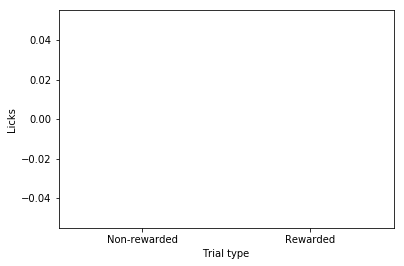

In [27]:
# Plot differences in licks in rewarded vs non-rewarded trials
%matplotlib inline
plt.bar((2,4),(len(licksNoReward),len(licksReward)))
plt.xticks([2,4],['Non-rewarded','Rewarded'])
plt.xlim((1,5))
plt.xlabel('Trial type')
plt.ylabel('Licks')
plt.show()

In [ ]:
# Add plot that tracks licks per trial for the two different Gabors across the session